# This Looks Like That There

Main training notebook.

In [1]:
import os
import sys
import time
import imp #imp.reload(module)

import numpy as np
from tqdm import trange
from icecream import ic

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf

import network
import experiment_settings 
import data_functions
import push_prototypes
import plots
import common_functions

In [2]:
__author__ = "Elizabeth A. Barnes and Randal J Barnes"
__version__ = "1 December 2021"

In [3]:
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 300.

## Print the detailed system info

In [4]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
numpy version = 1.21.5
tensorflow version = 2.9.0


## Define experiment settings and directories

In [5]:
EXP_NAME = 'fixed_fourteenday_precip'#'balanced_test'#initial_test'#'mjo'#'quadrants_testcase'

imp.reload(experiment_settings)
settings = experiment_settings.get_settings(EXP_NAME)

imp.reload(common_functions)
model_dir, model_diagnostics_dir, vizualization_dir = common_functions.get_exp_directories(EXP_NAME)

## Define the network parameters

In [6]:
RANDOM_SEED          = settings['random_seed']
BATCH_SIZE_PREDICT   = settings['batch_size_predict']
BATCH_SIZE           = settings['batch_size']
NLAYERS              = settings['nlayers']
NFILTERS             = settings['nfilters']   
assert(len(NFILTERS)==NLAYERS)

NCLASSES             = settings['nclasses']
PROTOTYPES_PER_CLASS = settings['prototypes_per_class']
NPROTOTYPES          = np.sum(PROTOTYPES_PER_CLASS)

NEPOCHS              = settings['nepochs']
LR_INIT              = settings['lr']
LR_CALLBACK_EPOCH    = settings['lr_cb_epoch']
PATIENCE             = 100

## Initialize

In [7]:
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Get and process the data

(73000, 64, 161, 1)


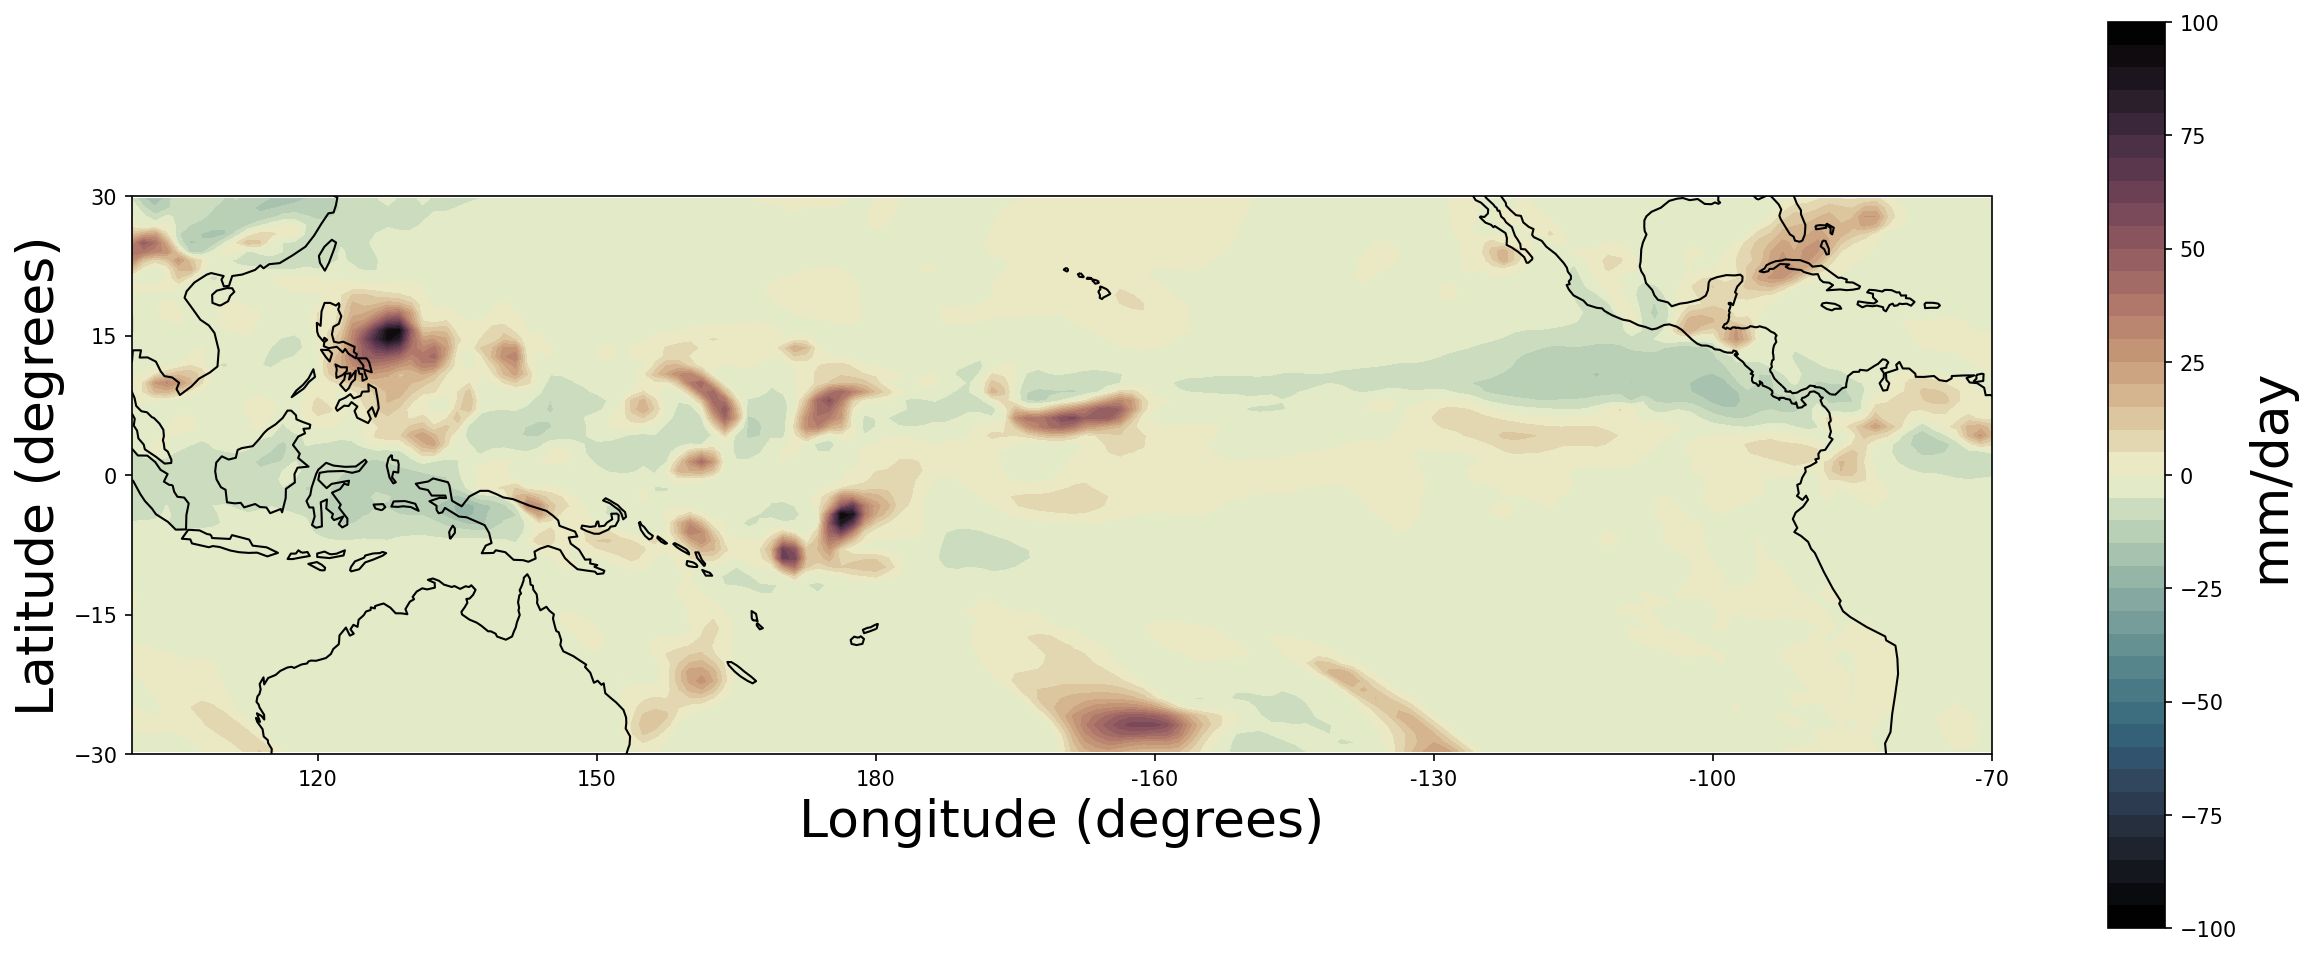

Mean: 2.7946985587509643e-05


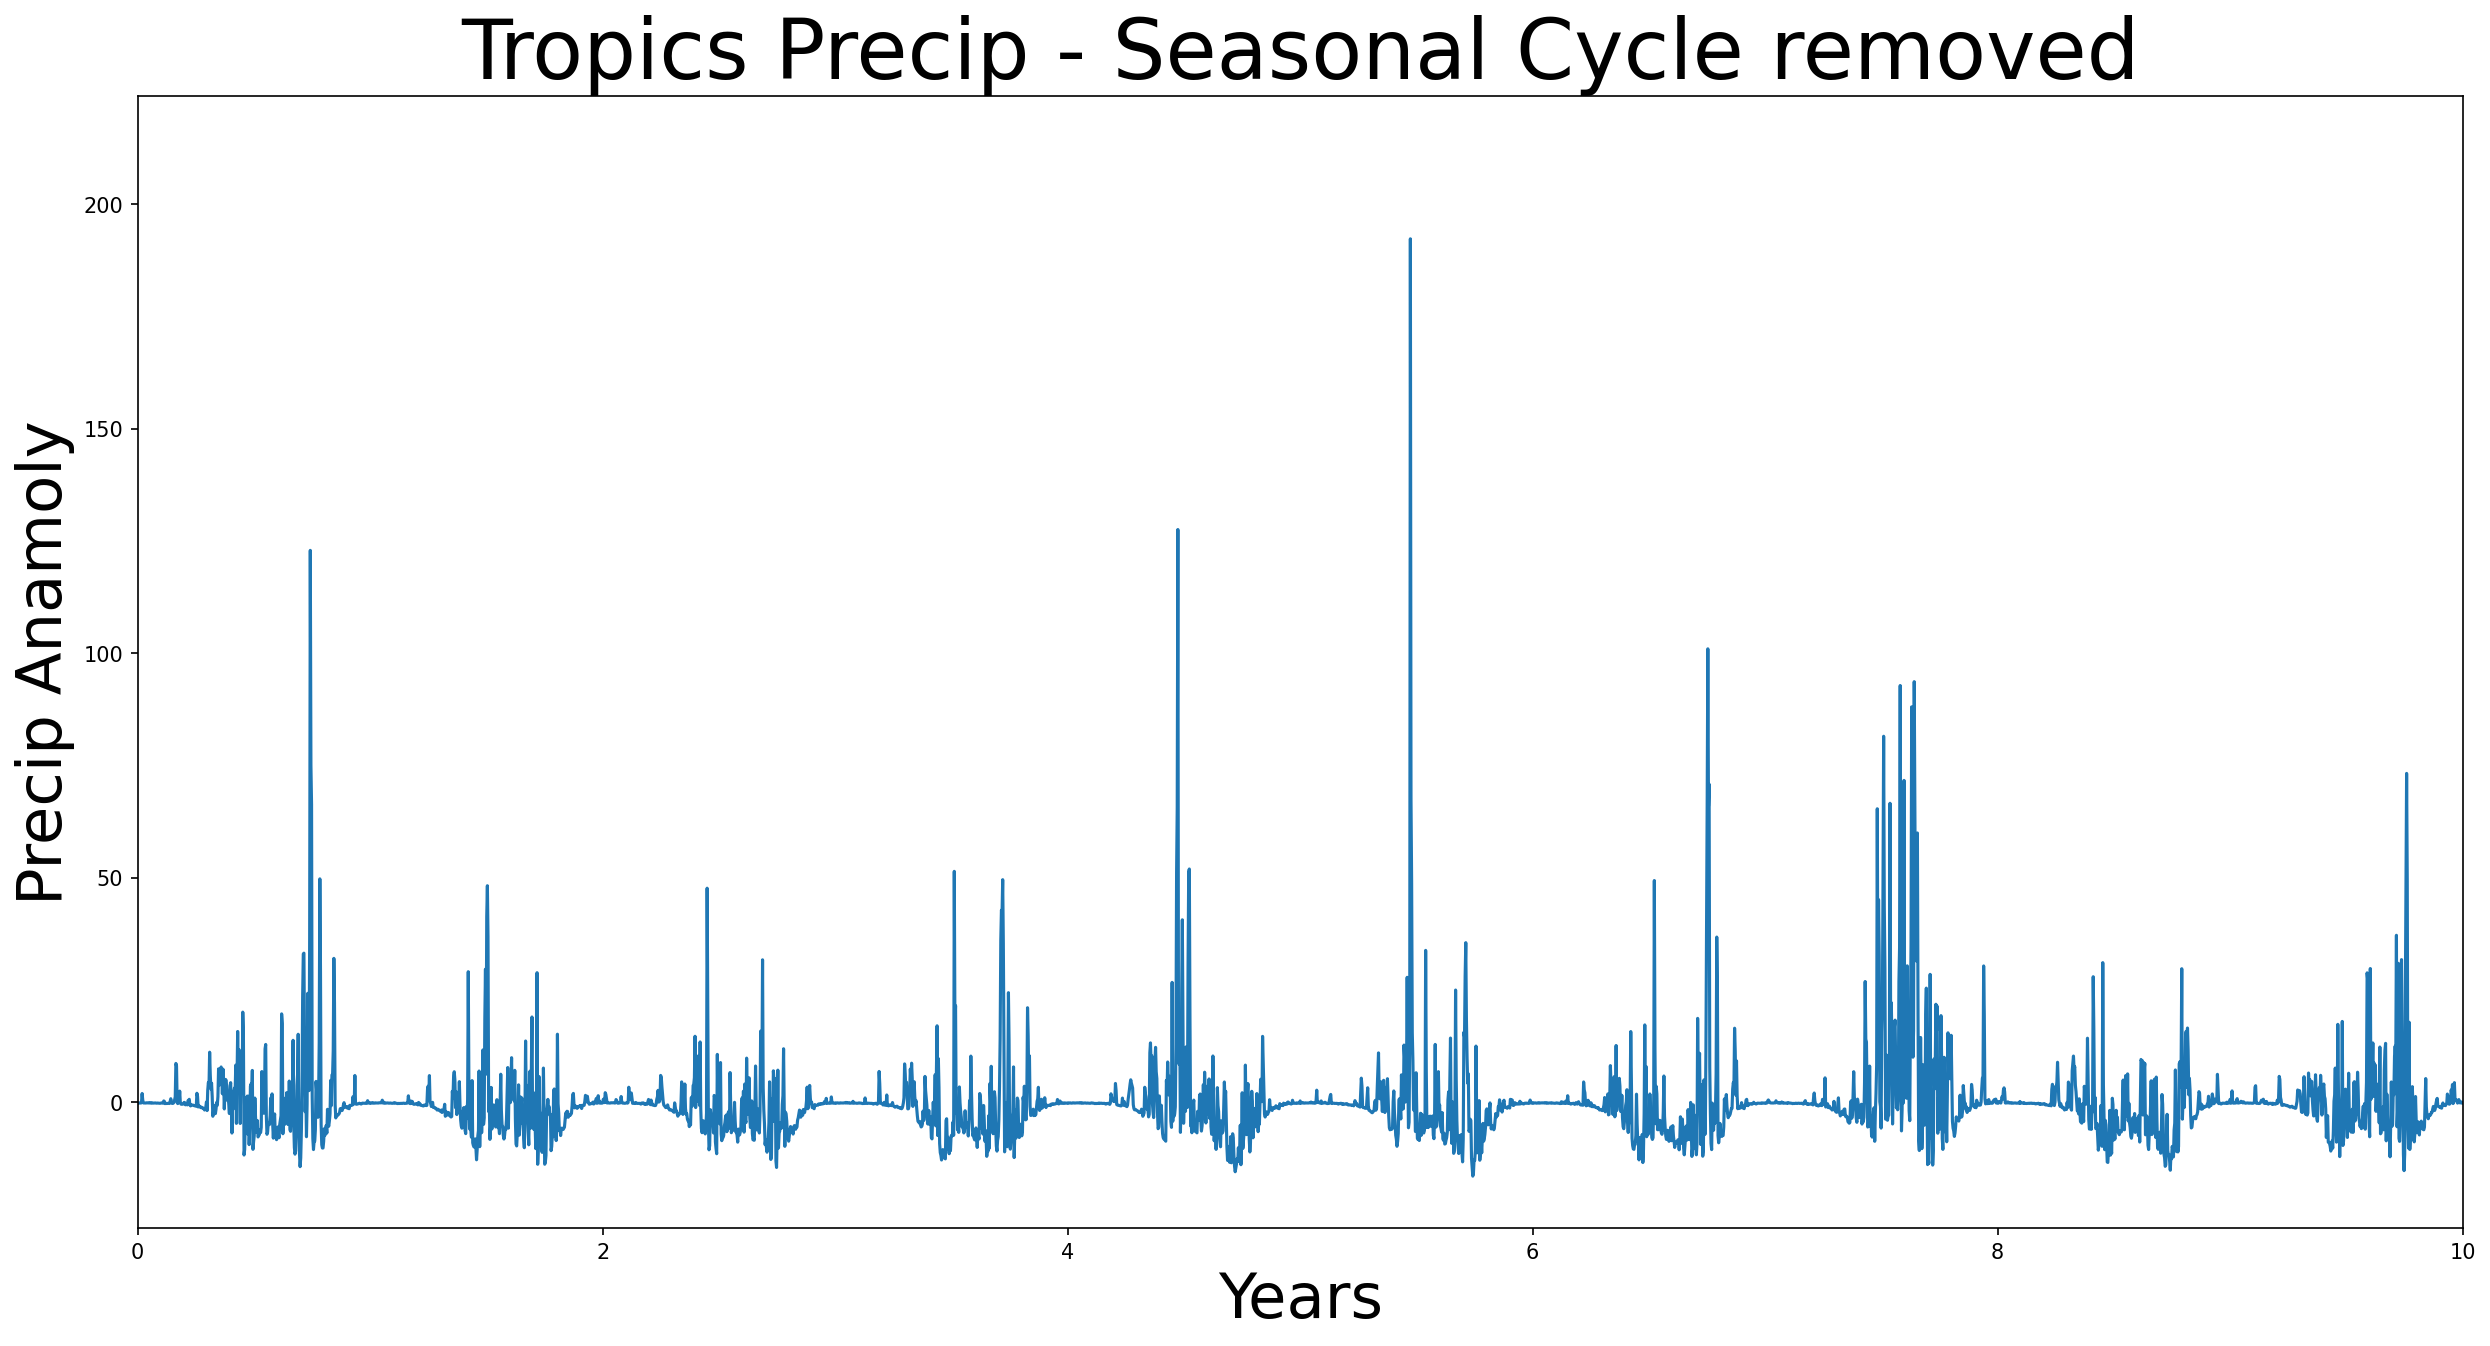

ic| years_train: array([1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810,
                        1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821,
                        1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832,
                        1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843,
                        1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854,
                        1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865,
                        1866, 1867, 1868, 1869])
ic| years_val: array([1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880,
                      1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891,
                      1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902,
                      1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913,
                      1914, 1915, 1916, 1917, 1918, 1919])


raw_data        = (73000, 64, 161, 1)
training data   = (25550, 64, 161, 1), (25550,)
validation data = (18250, 64, 161, 1), (18250,)
test data       = (29200, 64, 161, 1), (29200,)
X_mean          = -0.005196879444995845
X_std           = 7.504445948465378


In [8]:
imp.reload(data_functions)
DATA_NAME = settings['data_name']
DATA_DIR = settings['data_dir']

# print(data_functions)

if(EXP_NAME[:3]=='mjo'):

    labels, data, lat, lon, time = data_functions.load_mjo_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_mjo_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )        
elif(EXP_NAME[:9]=='quadrants'):
    filename = DATA_DIR + DATA_NAME + '.mat'
    X_train, y_train, X_val, y_val, X_test, y_test, lat, lon = data_functions.get_and_process_data(filename, 
                                                                                        rng, 
                                                                                        colored=settings['colored'],
                                                                                        standardize=settings['standardize'],
                                                                                        shuffle=settings['shuffle'],
                                                                                        )      
elif((EXP_NAME[:12]=='initial_test') or (EXP_NAME[:12]=='smaller_test') or (EXP_NAME[:13]=='balanced_test') or (EXP_NAME[:13]=='threeday_test') or (EXP_NAME[:12]=='zeroday_test') or (EXP_NAME[:16]=='fourteenday_test') or (EXP_NAME[:18]=='fourteenday_precip') or (EXP_NAME[:19]=='seventeenday_precip') or (EXP_NAME[:16]=='elevenday_precip') or (EXP_NAME[:30]=='fixed_fourteenday_precip')):

    labels, data, lat, lon, time = data_functions.load_pres_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_pres_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )
elif((EXP_NAME[:21]=='fourteenday_both_test') or ((EXP_NAME[:18]=='threeday_both_test'))):
    print("bingo")
    labels, data, lat, lon, time = data_functions.load_z500_precip_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_pres_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )

In [9]:
proto_class_mask = network.createClassIdentity(PROTOTYPES_PER_CLASS)

prototypes_of_correct_class_train = np.zeros((len(y_train),NPROTOTYPES))
for i in range(0,prototypes_of_correct_class_train.shape[0]):
    prototypes_of_correct_class_train[i,:] = proto_class_mask[:,int(y_train[i])]
    
prototypes_of_correct_class_val   = np.zeros((len(y_val),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_val.shape[0]):
    prototypes_of_correct_class_val[i,:] = proto_class_mask[:,int(y_val[i])]

prototypes_of_correct_class_test   = np.zeros((len(y_test),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_test.shape[0]):
    prototypes_of_correct_class_test[i,:] = proto_class_mask[:,int(y_test[i])]
    

## Define the training callbacks and metrics

In [10]:
# callbacks
def scheduler(epoch, lr):
    if epoch < LR_CALLBACK_EPOCH:
        return np.round(lr,8)
    else:
        if(epoch % 2 == 0):
            return lr/2.
        else:
            return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)    
    
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', 
    mode='max',
    patience=settings['patience'], 
    restore_best_weights=True, 
    verbose=1
)

callbacks_list = [
#     lr_callback,
#     es_callback,
]            

# metrics
metrics_list = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
]

2022-09-21 14:18:10.874851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Instantiate the model

In [11]:
__ = imp.reload(network)
tf.keras.backend.clear_session()

model = network.build_model(
    nlayers              = NLAYERS,
    nfilters             = NFILTERS,
    input_shape          = X_train.shape[1:],
    output_shape         = NCLASSES,
    prototypes_per_class = PROTOTYPES_PER_CLASS,
    network_seed         = RANDOM_SEED,    
    prototype_channels   = settings['prototype_channels'],    
    coeff_cluster        = settings['coeff_cluster'],
    coeff_separation     = settings['coeff_separation'],
    coeff_l1             = settings['coeff_l1'],
    incorrect_strength   = settings['incorrect_strength'],
    double_conv          = settings['double_conv'],
    kernel_l1_coeff      = 0.0,#settings['kernel_l1_coeff'],
    kernel_l2_coeff      = 0.0,#settings['kernel_l2_coeff'],
    drop_rate            = 0.0,
    drop_rate_final      = 0.0,        
    
)
model.summary()

3
[16, 16, 16]
(64, 161, 1)
3
[10, 10, 10]
30
False
0.2
-0.02
0.1
-0.5
False
8
64
0.0
0.0
0.0
0.0
False
Model: "full_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 64, 161, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv_0 (Conv2D)                (None, 64, 161, 16)  160         ['inputs[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 64, 161, 16)  0           ['conv_0[0][0]']                 
                                                                                    

## Load pre-trained weights into convolutional layers

In [12]:
if(settings['pretrain'] == True):

    if(settings['pretrain_exp'] is None):
        PRETRAINED_MODEL = model_dir + 'pretrained_model_' + EXP_NAME 
    else:
        PRETRAINED_MODEL = './saved_models/' + settings['pretrain_exp'] 

    print('loading pretrained convolutional layers from ' + PRETRAINED_MODEL)
    pretrained_model = tf.keras.models.load_model(PRETRAINED_MODEL)

    for layer in range(1,len(model.layers)):
        if(model.layers[layer].name[:4]=='conv'):
            print('   loading pretrained weights for --> ' + model.layers[layer].name)
            model.layers[layer].set_weights(pretrained_model.layers[layer].get_weights())
else:
    print('no pretrained model specified. keeping random initialized weights.')
    

loading pretrained convolutional layers from ./saved_models/fixed_fourteenday_precip/pretrained_model_fixed_fourteenday_precip
   loading pretrained weights for --> conv_0
   loading pretrained weights for --> conv_1
   loading pretrained weights for --> conv_2


In [13]:
# raise ValueError('here')

***

# Run Training Stages

In [14]:
imp.reload(network)
imp.reload(plots)
imp.reload(push_prototypes)
imp.reload(experiment_settings)
settings = experiment_settings.get_settings(EXP_NAME)

In [15]:
ic(np.shape(X_train))
ic(np.shape(prototypes_of_correct_class_train))
ic(np.shape(prototypes_of_correct_class_train))

ic| np.shape(X_train): (25550, 64, 161, 1)
ic| np.shape(prototypes_of_correct_class_train): (25550, 30)
ic| np.shape(prototypes_of_correct_class_train): (25550, 30)


(25550, 30)

In [16]:
imp.reload(push_prototypes)
NEPOCHS    = settings['nepochs']
STAGE_LIST = (0,1,2,3,4,5,6,7,8,9)#range(len(NEPOCHS))#(1,2,3,4,5)#range(len(NEPOCHS))

for stage in STAGE_LIST:
    
    print('--------------------')
    print('TRAINING STAGE = ' + str(stage))
    print('--------------------')

    # load previously trained stage, unless it is the 0th stage
    if(stage != 0):
        tf.keras.backend.clear_session()
        model_filename = model_dir + 'model_' + EXP_NAME + '_stage' + str(stage-1)
#         model = common_functions.load_model(model_filename)
        model.load_weights(model_filename)
        
    # learn layers (during even numbered stages)
    if(stage % 2 == 0):
        # train prototypes layers (and possibly CNN layers)
        if(settings['pretrain']==False and settings['train_cnn_in_stage'] == True):
            model = network.set_trainable_layers(model, [True,True,True,False])            
        elif(settings['train_cnn_in_stage'] == False or stage==0):
            model = network.set_trainable_layers(model, [False,True,True,False])
        elif(settings['train_cnn_in_stage'] == True):
            model = network.set_trainable_layers(model, [True,True,True,False])            
        elif(stage >= settings['train_cnn_in_stage']):
            model = network.set_trainable_layers(model, [True,True,True,False])            
        else:
            model = network.set_trainable_layers(model, [False,True,True,False])
    else:
        #.......................................................
        # push the prototypes
        #.......................................................        
        model, push_info = push_prototypes.push(model, 
                                                [X_train,prototypes_of_correct_class_train], 
                                                prototypes_of_correct_class_train, 
                                                perform_push=True,
                                                batch_size=BATCH_SIZE_PREDICT,
                                                verbose=False,
                                               )        
        print('Push complete.\n')            

        # train weights layer only
        model = network.set_trainable_layers(model, [False,False,False,True])        

    #.......................................................
    # compile the model
    #.......................................................
    if(stage>=settings['cut_lr_stage']):
        lr_factor = 10.**(np.floor((stage-settings['cut_lr_stage']+2)/2))
    else:
        lr_factor = 1.
    if(LR_INIT/lr_factor<settings['min_lr']):
        lr_factor = LR_INIT/settings['min_lr']
    print('learning rate = ' + str(np.asarray(LR_INIT/lr_factor,dtype='float32')))

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=np.asarray(LR_INIT/lr_factor,dtype='float32'), 
        ),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics = metrics_list,
    )
#     model.summary()
    ic(np.min(model.layers[-3].get_weights()[1]),np.max(model.layers[-3].get_weights()[1]))

    #.......................................................
    # train the model
    #.......................................................
    print('Training the model...')    
    
    tf.random.set_seed(RANDOM_SEED)   
    np.random.seed(RANDOM_SEED)    
    history = model.fit(
        [X_train,prototypes_of_correct_class_train],
        y_train,
        validation_data=([[X_val,prototypes_of_correct_class_val]], [y_val]),
        batch_size=BATCH_SIZE,
        epochs=NEPOCHS[stage],
        shuffle=True,
        verbose=1,
        callbacks=callbacks_list
    )
    print('Training complete.\n')            
        

    # save the model at this training stage
    model_filename = model_dir + 'model_' + EXP_NAME + '_stage' + str(stage)
    common_functions.save_model(model, model_filename) 
    
    #.......................................................
    # plot results
    #.......................................................  
    try:
        # plot loss history of the model
        plots.plot_loss_history(history)
        plt.savefig(model_diagnostics_dir + EXP_NAME + '_loss_history_stage' + str(stage) + '.png', dpi=dpiFig)    
        plt.close()

        # plot the weights
        plots.plot_weights(model, PROTOTYPES_PER_CLASS)    
        plt.savefig(model_diagnostics_dir + EXP_NAME + '_weights_stage' + str(stage) + '.png', dpi=dpiFig)
        plt.close()
    except:
        print('not making plots...')
        plt.close()

ic| np.min(model.layers[-3].get_weights()[1]): 0.0
    np.max(model.layers[-3].get_weights()[1]): 0.0


--------------------
TRAINING STAGE = 0
--------------------
   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 0.01
Training the model...
Epoch 1/10
799/799 [==============================] - 39s 48ms/step - loss: 4.2077 - sparse_categorical_accuracy: 0.3735 - cluster_cost: 0.5114 - separation_cost: 0.4494 - l1_weights_cost: 3.0000 - val_loss: 4.1999 - val_sparse_categorical_accuracy: 0.3463 - val_cluster_cost: 0.4126 - val_separation_cost: 0.3770 - val_l1_weights_cost: 3.0000
Epoch 2/10
799/799 [==============================] - 30s 38ms/step - loss: 4.1452 - sparse_categorical_accuracy: 0.3921 - cluster_cost: 0.2375 - separation_cost: 0.2177 - l1_weights_cost: 3.0000 - val_loss: 4.2401 - val_sparse_categorical_accuracy: 0.3343 - val_cluster_cost: 0.2627 - val_separation_cost: 0.2

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage0/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage0/assets


--------------------
TRAINING STAGE = 1
--------------------
Running Prototype Push


2022-09-21 14:23:46.242688: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage0: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage0; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 4s 320ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 0.01


ic| np.min(model.layers[-3].get_weights()[1]): -1.1181331
    np.max(model.layers[-3].get_weights()[1]): 2.533236


Training the model...
Epoch 1/10
799/799 [==============================] - 34s 41ms/step - loss: 1.7343 - sparse_categorical_accuracy: 0.3657 - cluster_cost: 0.0254 - separation_cost: 0.0167 - l1_weights_cost: 0.2472 - val_loss: 1.2541 - val_sparse_categorical_accuracy: 0.3146 - val_cluster_cost: 0.0280 - val_separation_cost: 0.0166 - val_l1_weights_cost: 0.0375
Epoch 2/10
799/799 [==============================] - 25s 31ms/step - loss: 1.1424 - sparse_categorical_accuracy: 0.3919 - cluster_cost: 0.0254 - separation_cost: 0.0167 - l1_weights_cost: 0.0277 - val_loss: 1.2205 - val_sparse_categorical_accuracy: 0.3011 - val_cluster_cost: 0.0280 - val_separation_cost: 0.0166 - val_l1_weights_cost: 0.0233
Epoch 3/10
799/799 [==============================] - 24s 30ms/step - loss: 1.1380 - sparse_categorical_accuracy: 0.3920 - cluster_cost: 0.0254 - separation_cost: 0.0167 - l1_weights_cost: 0.0290 - val_loss: 1.1483 - val_sparse_categorical_accuracy: 0.3311 - val_cluster_cost: 0.0280 - val_

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage1/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage1/assets
2022-09-21 14:28:30.118622: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage1: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage1; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.1181331
    np.max(model.layers[-3].get_weights()[1]): 2.533236


--------------------
TRAINING STAGE = 2
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 0.01
Training the model...
Epoch 1/10
799/799 [==============================] - 78s 97ms/step - loss: 1.1271 - sparse_categorical_accuracy: 0.3567 - cluster_cost: 0.0673 - separation_cost: 0.0415 - l1_weights_cost: 0.0272 - val_loss: 1.1317 - val_sparse_categorical_accuracy: 0.3829 - val_cluster_cost: 0.0565 - val_separation_cost: 0.0394 - val_l1_weights_cost: 0.0272
Epoch 2/10
799/799 [==============================] - 66s 83ms/step - loss: 1.1209 - sparse_categorical_accuracy: 0.3996 - cluster_cost: 0.0580 - separation_cost: 0.0383 - l1_weights_cost: 0.0272 - val_loss: 1.2107 - val_sparse_categorical_accuracy: 0.2966 - val_cluster_cost: 0.0774 - val_separation_cost: 0.0256 - 

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage2/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage2/assets


--------------------
TRAINING STAGE = 3
--------------------
Running Prototype Push


2022-09-21 14:40:02.979730: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage2: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage2; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 5s 423ms/step


/Users/nicojg/opt/miniconda3/envs/env-tf-cartopy/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/nicojg/opt/miniconda3/envs/env-tf-cartopy/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 0.01


ic| np.min(model.layers[-3].get_weights()[1]): -1.5917944
    np.max(model.layers[-3].get_weights()[1]): 5.5799294


Training the model...
Epoch 1/10
799/799 [==============================] - 30s 36ms/step - loss: 3.1304 - sparse_categorical_accuracy: 0.3587 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.1670 - val_loss: 1.7023 - val_sparse_categorical_accuracy: 0.3849 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.1354
Epoch 2/10
799/799 [==============================] - 24s 30ms/step - loss: 2.2704 - sparse_categorical_accuracy: 0.3604 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.1210 - val_loss: 3.4723 - val_sparse_categorical_accuracy: 0.3075 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.1065
Epoch 3/10
799/799 [==============================] - 24s 30ms/step - loss: 2.1591 - sparse_categorical_accuracy: 0.3588 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0951 - val_loss: 2.6723 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage3/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage3/assets
2022-09-21 14:44:33.186493: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage3: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage3; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.5917944
    np.max(model.layers[-3].get_weights()[1]): 5.5799294


--------------------
TRAINING STAGE = 4
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 0.001
Training the model...
Epoch 1/10
799/799 [==============================] - 65s 81ms/step - loss: 1.1527 - sparse_categorical_accuracy: 0.3724 - cluster_cost: 0.0056 - separation_cost: 0.0037 - l1_weights_cost: 0.0275 - val_loss: 1.1540 - val_sparse_categorical_accuracy: 0.3499 - val_cluster_cost: 0.0098 - val_separation_cost: 0.0051 - val_l1_weights_cost: 0.0275
Epoch 2/10
799/799 [==============================] - 63s 79ms/step - loss: 1.1067 - sparse_categorical_accuracy: 0.4141 - cluster_cost: 0.0079 - separation_cost: 0.0047 - l1_weights_cost: 0.0275 - val_loss: 1.1533 - val_sparse_categorical_accuracy: 0.3464 - val_cluster_cost: 0.0089 - val_separation_cost: 0.0031 -

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage4/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage4/assets


--------------------
TRAINING STAGE = 5
--------------------
Running Prototype Push


2022-09-21 14:55:28.168179: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage4: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage4; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 3s 329ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 0.001


ic| np.min(model.layers[-3].get_weights()[1]): -1.6079701
    np.max(model.layers[-3].get_weights()[1]): 5.446442


Training the model...
Epoch 1/10
799/799 [==============================] - 29s 36ms/step - loss: 1.1150 - sparse_categorical_accuracy: 0.3719 - cluster_cost: 7.5484e-04 - separation_cost: 1.1057e-05 - l1_weights_cost: 0.0079 - val_loss: 1.2693 - val_sparse_categorical_accuracy: 0.3047 - val_cluster_cost: 8.0456e-04 - val_separation_cost: 8.3910e-06 - val_l1_weights_cost: 0.0067
Epoch 2/10
799/799 [==============================] - 25s 31ms/step - loss: 1.1117 - sparse_categorical_accuracy: 0.3977 - cluster_cost: 7.5462e-04 - separation_cost: 1.1082e-05 - l1_weights_cost: 0.0063 - val_loss: 1.2061 - val_sparse_categorical_accuracy: 0.2940 - val_cluster_cost: 8.0456e-04 - val_separation_cost: 8.3910e-06 - val_l1_weights_cost: 0.0057
Epoch 3/10
799/799 [==============================] - 25s 31ms/step - loss: 1.1096 - sparse_categorical_accuracy: 0.4004 - cluster_cost: 7.5491e-04 - separation_cost: 1.1082e-05 - l1_weights_cost: 0.0064 - val_loss: 1.1603 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage5/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage5/assets
2022-09-21 15:00:10.586960: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage5: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage5; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.6079701
    np.max(model.layers[-3].get_weights()[1]): 5.446442


--------------------
TRAINING STAGE = 6
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 1e-04
Training the model...
Epoch 1/10
799/799 [==============================] - 68s 84ms/step - loss: 1.0774 - sparse_categorical_accuracy: 0.3827 - cluster_cost: 0.0016 - separation_cost: 8.2764e-04 - l1_weights_cost: 0.0052 - val_loss: 1.1282 - val_sparse_categorical_accuracy: 0.3529 - val_cluster_cost: 0.0021 - val_separation_cost: 0.0013 - val_l1_weights_cost: 0.0052
Epoch 2/10
799/799 [==============================] - 64s 81ms/step - loss: 1.0741 - sparse_categorical_accuracy: 0.4222 - cluster_cost: 0.0018 - separation_cost: 8.9818e-04 - l1_weights_cost: 0.0052 - val_loss: 1.1294 - val_sparse_categorical_accuracy: 0.3495 - val_cluster_cost: 0.0015 - val_separation_cost: 

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage6/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage6/assets


--------------------
TRAINING STAGE = 7
--------------------
Running Prototype Push


2022-09-21 15:11:07.248870: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage6: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage6; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 4s 360ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 1e-04


ic| np.min(model.layers[-3].get_weights()[1]): -1.6079701
    np.max(model.layers[-3].get_weights()[1]): 5.42097


Training the model...
Epoch 1/10
799/799 [==============================] - 30s 36ms/step - loss: 1.0724 - sparse_categorical_accuracy: 0.3907 - cluster_cost: 2.4038e-04 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0024 - val_loss: 1.1117 - val_sparse_categorical_accuracy: 0.3628 - val_cluster_cost: 2.4458e-04 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0021
Epoch 2/10
799/799 [==============================] - 25s 31ms/step - loss: 1.0712 - sparse_categorical_accuracy: 0.4184 - cluster_cost: 2.4016e-04 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0020 - val_loss: 1.1223 - val_sparse_categorical_accuracy: 0.3408 - val_cluster_cost: 2.4458e-04 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0017
Epoch 3/10
799/799 [==============================] - 25s 31ms/step - loss: 1.0717 - sparse_categorical_accuracy: 0.4201 - cluster_cost: 2.4021e-04 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0020 - val_loss: 1.1147 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage7/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage7/assets
2022-09-21 15:15:41.207326: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage7: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage7; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.6079701
    np.max(model.layers[-3].get_weights()[1]): 5.42097


--------------------
TRAINING STAGE = 8
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 1e-05
Training the model...
Epoch 1/10
799/799 [==============================] - 70s 86ms/step - loss: 1.0679 - sparse_categorical_accuracy: 0.3966 - cluster_cost: 2.3963e-04 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0016 - val_loss: 1.1156 - val_sparse_categorical_accuracy: 0.3542 - val_cluster_cost: 2.3632e-04 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0016
Epoch 2/10
799/799 [==============================] - 63s 78ms/step - loss: 1.0676 - sparse_categorical_accuracy: 0.4273 - cluster_cost: 2.3875e-04 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0016 - val_loss: 1.1170 - val_sparse_categorical_accuracy: 0.3515 - val_cluster_cost: 2.3675e-04 - v

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage8/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage8/assets


--------------------
TRAINING STAGE = 9
--------------------
Running Prototype Push


2022-09-21 15:26:54.163222: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage8: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage8; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 4s 369ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 1e-05


ic| np.min(model.layers[-3].get_weights()[1]): -1.6079711
    np.max(model.layers[-3].get_weights()[1]): 5.4208193


Training the model...
Epoch 1/10
799/799 [==============================] - 35s 42ms/step - loss: 1.0662 - sparse_categorical_accuracy: 0.3943 - cluster_cost: 2.1765e-04 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0011 - val_loss: 1.1151 - val_sparse_categorical_accuracy: 0.3525 - val_cluster_cost: 2.2266e-04 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0010
Epoch 2/10
799/799 [==============================] - 26s 33ms/step - loss: 1.0659 - sparse_categorical_accuracy: 0.4259 - cluster_cost: 2.1745e-04 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0010 - val_loss: 1.1210 - val_sparse_categorical_accuracy: 0.3477 - val_cluster_cost: 2.2266e-04 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0010
Epoch 3/10
799/799 [==============================] - 28s 35ms/step - loss: 1.0661 - sparse_categorical_accuracy: 0.4252 - cluster_cost: 2.1750e-04 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0010 - val_loss: 1.1163 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage9/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage9/assets


In [17]:
"

SyntaxError: EOL while scanning string literal (1845220801.py, line 1)

In [ ]:
"test""test""test""test""test"